In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from datetime import datetime
%matplotlib inline

In [ ]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


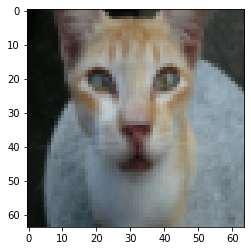

In [ ]:
index = 11
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [0], it's a 'non-cat' picture.


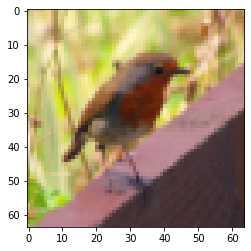

In [ ]:
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [ ]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

# **All below cells are exploiting DLP**

In [ ]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [ ]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0
    return w, b

In [ ]:
def propagate(w, b, X, Y):
    m = X.shape[1]
       # FORWARD PROPAGATION (FROM X TO COST)
    
    A = sigmoid( np.dot(w.T,X) + b )                                   # compute activation
    cost = -1 / m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))       # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)

    dw = 1/m * np.dot(X,(A - Y).T)
    db = 1/m * np.sum(A - Y)

    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate=0.009, print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
   
    A = sigmoid(np.dot(w.T, X) + b) 
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] > 0.5:
            Y_prediction[0,i] = 1 
        else:
            Y_prediction[0,i] = 0
        
    
    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate=0.5, print_cost=False):
    start = datetime.now()
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent 
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
   
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    end = datetime.now()
    total_time=end - start
    print(f"Runtime of the program is {total_time.total_seconds()} seconds")
    #print(start,end)
    return d

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147 5
Cost after iteration 100: 0.584508 5
Cost after iteration 200: 0.466949 5
Cost after iteration 300: 0.376007 5
Cost after iteration 400: 0.331463 5
Cost after iteration 500: 0.303273 5
Cost after iteration 600: 0.279880 5
Cost after iteration 700: 0.260042 5
Cost after iteration 800: 0.242941 5
Cost after iteration 900: 0.228004 5
Cost after iteration 1000: 0.214820 5
Cost after iteration 1100: 0.203078 5
Cost after iteration 1200: 0.192544 5
Cost after iteration 1300: 0.183033 5
Cost after iteration 1400: 0.174399 5
Cost after iteration 1500: 0.166521 5
Cost after iteration 1600: 0.159305 5
Cost after iteration 1700: 0.152667 5
Cost after iteration 1800: 0.146542 5
Cost after iteration 1900: 0.140872 5
Cost after iteration 2000: 0.135608 5
Cost after iteration 2100: 0.130708 5
Cost after iteration 2200: 0.126137 5
Cost after iteration 2300: 0.121861 5
Cost after iteration 2400: 0.117855 5
Cost after iteration 2500: 0.114093 5
Cost after iteration 260

y = 0, you predicted that it is a "non-cat" picture.


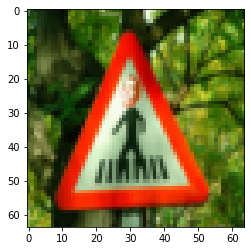

In [ ]:
# Example of a picture that was wrongly classified.
index = 14
plt.imshow(test_set_x[:,index].reshape((64, 64, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")